<a href="https://colab.research.google.com/github/davidanagy/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module1-statistics-probability-and-inference/LS_DS_131_Statistics_Probability_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 1 Sprint 3 Assignment 1*

# Apply the t-test to real data

Your assignment is to determine which issues have "statistically significant" differences between political parties in this [1980s congressional voting data](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records). The data consists of 435 instances (one for each congressperson), a class (democrat or republican), and 16 binary attributes (yes or no for voting for or against certain issues). Be aware - there are missing values!

Your goals:

1. Load and clean the data (or determine the best method to drop observations when running tests)
2. Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01
3. Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01
4. Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)

Note that this data will involve *2 sample* t-tests, because you're comparing averages across two groups (republicans and democrats) rather than a single group against a null hypothesis.

Stretch goals:

1. Refactor your code into functions so it's easy to rerun with arbitrary variables
2. Apply hypothesis testing to your personal project data (for the purposes of this notebook you can type a summary of the hypothesis you formed and tested)

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2019-09-16 19:01:50--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.06s   

2019-09-16 19:01:50 (286 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('house-votes-84.data', header=None, names=[
    'party', 'handicapped_infants', 'water_project_cost_sharing', 'adoption_of_the_budget_resolution',
    'physician_fee_freeze', 'el_salvador_aid', 'religious_groups_in_schools', 'anti_satellite_test_ban',
    'aid_to_nicaraguan_contras', 'mx_missile', 'immigration', 'synfuels_corporation_cutback', 'education_spending',
    'superfund_right_to_sue', 'crime', 'duty_free_exports', 'export_administration_act_south_africa'],
                true_values='y', false_values='n', na_values='?')

print(df.shape)

df.head()

(435, 17)


,party,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
0,republican,False,True,False,True,True,True,False,False,False,True,NaN,True,True,True,False,True
1,republican,False,True,False,True,True,True,False,False,False,False,False,True,True,True,False,NaN
2,democrat,NaN,True,True,NaN,True,True,False,False,False,False,True,False,True,True,False,False
3,democrat,False,True,True,False,NaN,True,False,False,False,False,True,False,True,False,False,True
4,democrat,True,True,True,False,True,True,False,False,False,False,True,NaN,True,True,True,True


According to the dataset notes, the missing values are not actually unknown values; they mean one of the following: "voted present, voted present to avoid conflict of interest, and did not vote or otherwise make a position known."

One option is to just ignore these values, but I don't like that since voting present does mean *something*. I think it makes the most sense to replace the present votes (i.e. the NaN values) with 0.5, since that feels analogous to how the representative in question refused to take a stand one way or another.

In [14]:
df = df.fillna(value=0.5)

df.head(20)

,party,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
0,republican,False,True,False,True,True,True,False,False,False,True,0.5,True,True,True,False,True
1,republican,False,True,False,True,True,True,False,False,False,False,False,True,True,True,False,0.5
2,democrat,0.5,True,True,0.5,True,True,False,False,False,False,True,False,True,True,False,False
3,democrat,False,True,True,False,0.5,True,False,False,False,False,True,False,True,False,False,True
4,democrat,True,True,True,False,True,True,False,False,False,False,True,0.5,True,True,True,True
5,democrat,False,True,True,False,True,True,False,False,False,False,False,False,True,True,True,True
6,democrat,False,True,False,True,True,True,False,False,False,False,False,False,0.5,True,True,True
7,republican,False,True,False,True,True,True,False,False,False,False,False,False,True,True,0.5,True
8,republican,False,True,False,True,True,True,False,False,False,False,False,True,True,True,False,True
9,democrat,True,True,True,False,False,False,True,True,True,False,False,False,False,False,0.5,0.5


Just taking a quick look at these first 20 rows, I hypothesize the following:

Democrats vote "Yes" more than Republicans on: handicapped infants; adoption of the budget resolution; anti-satellite test ban; aid to nicaraguan contras; mx missile; synfuels corportion cutback; duty-free exports; export administration act south africa

Republicans vote "Yes" more than Democrats on: physician fee freeze; el salvador aid; religious groups in schools; superfund right to use; crime

They vote about the same on: water project; immigration; education spending

In all these 2-sample T-Tests, the null hypothesis is that Democrats and Republicans voted the same.

In [15]:
dem = df[df['party'] == 'democrat']
rep = df[df['party'] == 'republican']

dem.head()

,party,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
2,democrat,0.5,True,True,0.5,True,True,False,False,False,False,True,False,True,True,False,False
3,democrat,False,True,True,False,0.5,True,False,False,False,False,True,False,True,False,False,True
4,democrat,True,True,True,False,True,True,False,False,False,False,True,0.5,True,True,True,True
5,democrat,False,True,True,False,True,True,False,False,False,False,False,False,True,True,True,True
6,democrat,False,True,False,True,True,True,False,False,False,False,False,False,0.5,True,True,True


In [25]:
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel

# First, I'll test the mx missile (since I'm actually curious about it).

test1 = ttest_ind(dem['mx_missile'], rep['mx_missile'])
test1

Ttest_indResult(statistic=16.326540222505376, pvalue=4.863267267890594e-47)

The p-statistic is positive and the p-value is much lower than 0.01, so the null hypothesis is rejected; Democrats did indeed support the MX Missile more than Republicans to a statistically significant degree.

In [26]:
# Now I'll try "el salvador aid" for a potential issue that Republicans support more than Democrats.

test2 = ttest_ind(rep['el_salvador_aid'], dem['el_salvador_aid'])
test2

Ttest_indResult(statistic=20.89561712304093, pvalue=1.4659659186473623e-67)

Once more, the p-statistic is positive and the p-value is much lower than 0.01, so the null hypothesis is rejected; Republicans did indeed support aid to El Salvador more than Democrats to a statistically significant degree.

In [27]:
# Finally, let's look at education spending.

test3 = ttest_ind(dem['education_spending'], rep['education_spending'])
test3

Ttest_indResult(statistic=-19.74462398332552, pvalue=2.383628490538625e-62)

My initial hypothesis was wrong! Republicans supported this more than Democrats. Let's try something else.

In [28]:
test4 = ttest_ind(dem['immigration'], rep['immigration'])
test4

Ttest_indResult(statistic=-1.7350166356866625, pvalue=0.083449397203073)

This p-value is much higher than in previous cases, but it's just short of 0.1. How about the water project, then?

In [29]:
test5 = ttest_ind(dem['water_project_cost_sharing'], rep['water_project_cost_sharing'])
test5

Ttest_indResult(statistic=-0.0876455988442189, pvalue=0.9301988772663681)

An extremely high p-value! I fail to reject the null hypothesis.

### Results:

Democrats supported **the MX Missile** more than Republicans to a statistically significant degree.

Republicans supported **aid to El Salvador** more than Democrats to a statistically significant degree.

Democratic and Republican support for **water project cost sharing** did not exhibit a statistically significant difference.

The following was added to this assignment:

-You also practice some 1-sample t-tests

-You try and create some kind of a visualization that communicates the results of your hypothesis tests. This can be as simple as a histogram of the p-values or the t-statistics.

In [22]:
from scipy.stats import ttest_1samp

ttest_1samp(rep['synfuels_corporation_cutback'], 0)

# Due to the low p-value, I reject the null hypothesis that Republican support for
# the synfuels corporation cutback was 0, and conclude that it was not 0.

Ttest_1sampResult(statistic=5.775277960563392, pvalue=3.663862845744906e-08)

In [23]:
ttest_1samp(dem['crime'], .5)

# Due to the low p-value, I reject the null hypothesis that Democratic support for
# the "crime" measure was 50% and conclude that it was not 50% (specifically, it was lower).

Ttest_1sampResult(statistic=-5.015709886862045, pvalue=9.668863754086526e-07)

###Visualization:

In [70]:
tests = [test1, test2, test3, test4, test5]
temp = []

for test in tests:
  temp.append(pd.DataFrame(test).transpose()) # Transpose so I can have only two columns.

data = pd.concat(temp, ignore_index=True) # Get all my data into one dataframe.

data.at[1,0] = -20.895617 # Change this value to negative so the positives and negatives are consistent.
                     
data

,0,1
0,16.326540,4.863267e-47
1,-20.895617,1.465966e-67
2,-19.744624,2.383628e-62
3,-1.735017,8.344940e-02
4,-0.087646,9.301989e-01


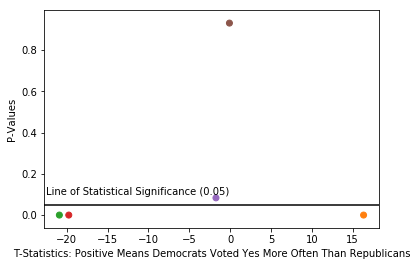

In [90]:
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots()

scatter = ax.scatter(data[0], data[1], c=['C1', 'C2', 'C3', 'C4', 'C5'])
ax.axhline(y=0.05, color='black');
ax.set_xlabel('T-Statistics: Positive Means Democrats Voted Yes More Often Than Republicans')
ax.set_ylabel('P-Values')
ax.text(x=-22.5, y=0.1, s='Line of Statistical Significance (0.05)');

# I tried to make a legend but ran into problems...

### Stretch Goal 1:

In [95]:
def party_ttest(vote, rep_first=False):
  if rep_first==False:
    return ttest_ind(dem[vote], rep[vote])
  else:
    return ttest_ind(rep[vote], dem[vote])

print(party_ttest('water_project_cost_sharing'))
print(party_ttest('el_salvador_aid', rep_first=True))

Ttest_indResult(statistic=-0.0876455988442189, pvalue=0.9301988772663681)
Ttest_indResult(statistic=20.89561712304093, pvalue=1.4659659186473623e-67)


In [98]:
def party_ttest_1samp(party, vote, null_hyp):
  if party=='Democrat':
    return ttest_1samp(dem[vote], null_hyp)
  elif party=='Republican':
    return ttest_1samp(rep[vote], null_hyp)
  else:
    print('Please enter the party as "Democrat" or "Republican."')
    
print(party_ttest_1samp('Republican', 'synfuels_corporation_cutback', 0))
print(party_ttest_1samp('Democrat', 'crime', 0.5))
print(party_ttest_1samp('dem', 'crime', 0.5))

Ttest_1sampResult(statistic=5.775277960563392, pvalue=3.663862845744906e-08)
Ttest_1sampResult(statistic=-5.015709886862045, pvalue=9.668863754086526e-07)
Please enter the party as "Democrat" or "Republican."
None


### Stretch Goal 2:

(To be honest, while I have an idea, I still haven't 100% decided on my project topic or dataset. But I'll use what I've got for now.)

Project Topic: What does it mean to forecast a probability for an individual event, such as an election?

Argument: Forecasting an election result is meaningful in some senses, but giving it a specific numerical probability is always arbitrary, because it's a unique event that cannot in principle be repeated.

Objection: The accuracy of a predictive method can be tested by doing calibration on *all* predictions done with that method.

Response: Calibration is only meaningful if we choose a specific subset of predictions to collect together and calibrate, and that choice is arbitrary when it comes to unique events like elections.

To show this, **I make the following prediction:** There is a larger (statistical) difference between 538's projection error and an unskilled error (here unskilled means guessing Trump will win 50% of the vote in all states) when we look at *only the general election*, versus when we look at *only elections involving Trump*.

In the course of this objection and response, I will use 538's dataset of their predictions (and the actual outcomes of the forecasted events): https://github.com/fivethirtyeight/checking-our-work-data

In [136]:
primary = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/checking-our-work-data/master/presidential_primaries.csv')

general = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/checking-our-work-data/master/presidential_elections.csv')

print(primary.shape)

primary.head()

(9945, 13)


,year,office,state,special,election_date,forecast_date,forecast_type,party,candidate,projected_voteshare,actual_voteshare,probwin,probwin_outcome
0,2016,Democratic presidential primary,Alabama,NaN,2016-03-01,2016-03-01,polls-only,D,Sanders,25.698812,19.17,0.0,0
1,2016,Democratic presidential primary,Alabama,NaN,2016-03-01,2016-03-01,polls-plus,D,Sanders,23.196432,19.17,0.0,0
2,2016,Democratic presidential primary,Alabama,NaN,2016-03-01,2016-03-01,polls-only,D,Clinton,71.369629,77.88,1.0,1
3,2016,Democratic presidential primary,Alabama,NaN,2016-03-01,2016-03-01,polls-plus,D,Clinton,73.872009,77.88,1.0,1
4,2016,Democratic presidential primary,Alabama,NaN,2016-03-01,2016-02-29,polls-only,D,Sanders,25.699083,19.17,0.0,0


In [137]:
print(general.shape)

general.head()

(97394, 13)


,year,office,state,district,election_date,forecast_date,forecast_type,party,candidate,projected_voteshare,actual_voteshare,probwin,probwin_outcome
0,2016,President,AL,NaN,2016-11-08,2016-11-08,polls-plus,R,Trump,58.193710,62.08,0.99915,1
1,2016,President,AL,NaN,2016-11-08,2016-11-08,polls-plus,D,Clinton,35.841850,34.36,0.00085,0
2,2016,President,AL,NaN,2016-11-08,2016-11-08,polls-plus,L,Johnson,4.215338,2.09,0.00000,0
3,2016,President,AK,NaN,2016-11-08,2016-11-08,polls-plus,R,Trump,48.447200,51.28,0.78535,1
4,2016,President,AK,NaN,2016-11-08,2016-11-08,polls-plus,D,Clinton,40.652500,36.55,0.21435,0


In [138]:
primary0 = primary.drop(['year', 'special', 'election_date', 'forecast_date',
                        'forecast_type', 'party'], axis=1)
general0 = general.drop(['year', 'district', 'election_date', 'forecast_date',
                        'forecast_type', 'party'], axis=1)

primary_trump = primary0[primary0['candidate']=='Trump']
general_trump = general0[general0['candidate']=='Trump']

trump = pd.concat([primary_trump, general_trump])
trump = trump.drop(['candidate'], axis=1)
trump = trump.replace({'Republican presidential primary': 'Primary', 'President': 'General'})

print(trump.shape)
trump.head()

(26998, 6)


,office,state,projected_voteshare,actual_voteshare,probwin,probwin_outcome
10,Primary,Alabama,43.421524,43.42,0.96195,1
11,Primary,Alabama,41.426022,43.42,0.94255,1
20,Primary,Alabama,43.406273,43.42,0.96690,1
21,Primary,Alabama,41.387596,43.42,0.94810,1
30,Primary,Alabama,39.055584,43.42,0.85285,1


In [139]:
trump['forecast_error'] = (abs(trump['actual_voteshare'] - trump['projected_voteshare']))
trump['unskilled_error'] = (abs(trump['actual_voteshare'] - 50))

trump.head()

,office,state,projected_voteshare,actual_voteshare,probwin,probwin_outcome,forecast_error,unskilled_error
10,Primary,Alabama,43.421524,43.42,0.96195,1,0.001524,6.58
11,Primary,Alabama,41.426022,43.42,0.94255,1,1.993978,6.58
20,Primary,Alabama,43.406273,43.42,0.96690,1,0.013727,6.58
21,Primary,Alabama,41.387596,43.42,0.94810,1,2.032404,6.58
30,Primary,Alabama,39.055584,43.42,0.85285,1,4.364416,6.58


In [140]:
general['forecast_error'] = (abs(general['actual_voteshare'] - general['projected_voteshare']))
general['unskilled_error'] = (abs(general['actual_voteshare'] - 50))

general.head()

,year,office,state,district,election_date,forecast_date,forecast_type,party,candidate,projected_voteshare,actual_voteshare,probwin,probwin_outcome,forecast_error,unskilled_error
0,2016,President,AL,NaN,2016-11-08,2016-11-08,polls-plus,R,Trump,58.193710,62.08,0.99915,1,3.886290,12.08
1,2016,President,AL,NaN,2016-11-08,2016-11-08,polls-plus,D,Clinton,35.841850,34.36,0.00085,0,1.481850,15.64
2,2016,President,AL,NaN,2016-11-08,2016-11-08,polls-plus,L,Johnson,4.215338,2.09,0.00000,0,2.125338,47.91
3,2016,President,AK,NaN,2016-11-08,2016-11-08,polls-plus,R,Trump,48.447200,51.28,0.78535,1,2.832800,1.28
4,2016,President,AK,NaN,2016-11-08,2016-11-08,polls-plus,D,Clinton,40.652500,36.55,0.21435,0,4.102500,13.45


In [153]:
ttest_ind(general['forecast_error'], general['unskilled_error'], nan_policy='omit')

Ttest_indResult(statistic=-266.9346018495316, pvalue=0.0)

In [154]:
ttest_ind(trump['forecast_error'], trump['unskilled_error'], nan_policy='omit')

Ttest_indResult(statistic=-83.56895510990347, pvalue=0.0)

My hypothesis is confirmed! If we're trying to judge 538's accuracy in predicting the 2020 election by comparing it to an unskilled guesser, our confidence varies depending on if we look at "all general elections" or "all elections involving Trump." Since the choice between those is arbitrary, this method cannot be used to attach meaning to a numerical probability for Trump's reelection.